In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from time import sleep
from tqdm import tqdm
import json
import math

In [3]:
API_KEY1 = "68bda7d9-8134-433d-a7d8-2568eaad6cd6"
API_KEY2 = "..." # вставить второй ключ

#Обращения к API

берем эти города

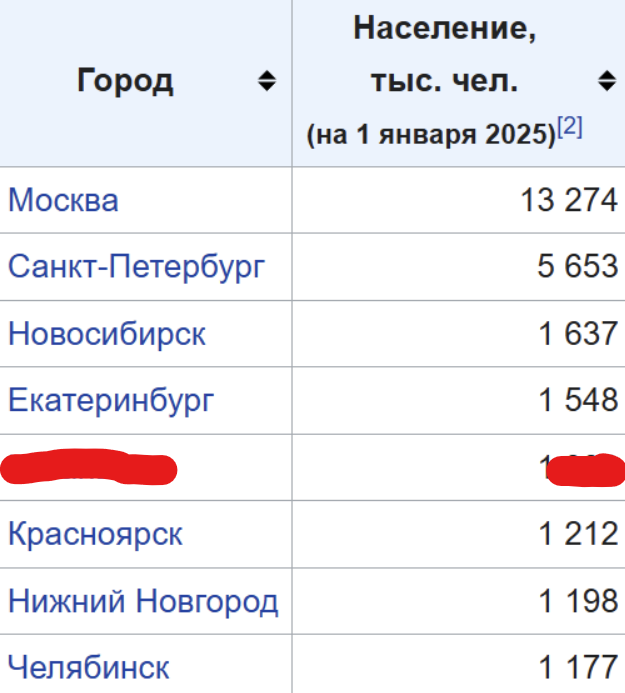

In [4]:
BOX = {
    "Москва": (37.30, 37.95, 55.55, 55.95),
    "Санкт-Петербург": (30.10, 30.50, 59.80, 60.10),
    "Новосибирск": (82.72, 83.17, 54.80, 55.20),
    "Екатеринбург": (60.45, 60.75, 56.70, 57.00),
    "Красноярск": (92.70, 93.15, 56.00, 56.15),
    "Нижний Новгород": (43.60, 44.10, 56.15, 56.40),
    "Челябинск": (61.30, 61.65, 55.00, 55.35),
}

CITIES = [
    "Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург",
    "Красноярск", "Нижний Новгород", "Челябинск",
]

In [5]:
cities_df = pd.DataFrame(columns=["city", "lon_min", "lon_max", "lat_min", "lat_max"])
i=0

for city in CITIES:
  lon_min, lon_max, lat_min, lat_max = BOX[city]
  cities_df.loc[i] = [city, lon_min, lon_max, lat_min, lat_max]
  i+=1

cities_df.to_csv("cities.csv", index=False)
print("Сохранено как 'cities.csv'")


Сохранено как 'cities.csv'


In [6]:
cities_df = pd.read_csv("cities.csv")
cities_df

,city,lon_min,lon_max,lat_min,lat_max
0,Москва,37.30,37.95,55.55,55.95
1,Санкт-Петербург,30.10,30.50,59.80,60.10
2,Новосибирск,82.72,83.17,54.80,55.20
3,Екатеринбург,60.45,60.75,56.70,57.00
4,Красноярск,92.70,93.15,56.00,56.15
5,Нижний Новгород,43.60,44.10,56.15,56.40
6,Челябинск,61.30,61.65,55.00,55.35


In [7]:
import logging
logger1 = logging.getLogger("2GIS_API.region") # вернет один и тот же объект для этого имени в любом месте программы
logger1.setLevel(logging.INFO)  # отсекает все записи ниже INFO на уровне логгера. То есть debug не пройдет дальше по цепочке, а info, warning, error, critical будут обработаны

fh1 = logging.FileHandler("RegionLogs.log") # открывает файл в текущей рабочей директории и будет записывать туда строки

formatter1 = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s') # определяет, как будет выглядеть запись в логах
fh1.setFormatter(formatter1) # Назначает форматтер обработчику

logger1.addHandler(fh1) #добавляет обработчик логгеру

In [8]:
def get_region_id(city: str) -> str:
  try:
      r = requests.get(
          "https://catalog.api.2gis.com/2.0/region/search",
          params={"q": city, "key": API_KEY1, "locale": "ru_RU"},
          headers={"accept": "application/json"},
          timeout=20,
      )
      r.raise_for_status() # проверка на ошибки типа 4xx и 5xx, если ккод не 200, то вызовет requests.exceptions.HTTPError
      # r.json() в случае ошибки будет таким: {'meta': {'api_version': '2.0.19411', 'code': 403, 'error': {'message': 'Authorization error, incorrect key.', 'type': 'forbidden'}, 'issue_date': '20251111'}}
      # r.json() в случае успеха будет таким: {'meta': {'api_version': '2.0.19411', 'code': 200, 'issue_date': '20251111'}, 'result': {'items': [{'id': '32', 'name': 'Москва', 'type': 'region'}], 'total': 1}}
      code = r.json()["meta"]["code"] # получаем 'code' из r.json()

      if code != 200: # если код не 200, то вызываем RuntimeError чтобы обработать ошибку
          message = r.json()["meta"]["error"]["message"]
          raise RuntimeError("RuntimeError")

      items = r.json()["result"]["items"]  # если код 200, то ищем id бара и передаем дальше
      logger1.info(f"Determined region_id for city {city} : {items[0]['id']} ")

      return items[0]["id"]

  except requests.exceptions.HTTPError as e:
      logger1.error(f"HTTPError occurred: '{e}' while determining region_id for city '{city}'")
  except RuntimeError as e:
      logger1.error(f"Error occurred: '{e}' while determining region_id for city '{city}'. code: {code}, message: {message}")
  except Exception as e:
      logger1.error(f"Unexpected error: '{e}' while determining region_id for city '{city}'")

def get_bar_rubric_id(region_id: str) -> str:
    try:
        r = requests.get(
            "https://catalog.api.2gis.com/2.0/catalog/rubric/search",
            params={"q": "бар", "region_id": region_id, "key": API_KEY1, "locale": "ru_RU"},
            headers={"accept": "application/json"},
            timeout=20,
        )
        r.raise_for_status()
        code = r.json()["meta"]["code"]
        # r.json() в случае ошибки будет таким: {'meta': {'api_version': '2.0.19411', 'code': 403, 'error': {'message': 'Authorization error, incorrect key.', 'type': 'forbidden'}, 'issue_date': '20251111'}}
        # r.json() в случае успеха будет таким: {'meta': {'api_version': '2.0.19411', 'code': 200, 'issue_date': '20251111'}, 'result': {'items': [{'alias': 'bary', 'branch_count': 2565, 'caption': 'Бары', 'id': '159', 'keyword': 'Бары', \
        # 'name': 'Бары', 'org_count': 2011, 'parent_id': '2', 'seo_name': 'Бары / Пабы', 'title': 'Бары', 'type': 'rubric'}, {'alias': 'barbershopy', 'branch_count': 2509, 'caption': 'Барбершопы', 'id': '110998',... и так далее все совпадения по слову "бар"

        if code != 200: # если код не 200, то вызываем RuntimeError чтобы обработать ошибку
            message = r.json()["meta"]["error"]["message"]
            raise RuntimeError("RuntimeError")

        items = r.json()["result"]["items"]
        for rb in items:
            # Строгое совпадение по alias исключает 'суши-бары', 'барбершопы' и пр.
            if (rb.get("alias") or "").lower() == "bary":
                logger1.info(f"Determined bar_id: {rb['id']}")
                return rb["id"]

        # fallback: на случай, если alias отсутствует — проверим точное 'name'
        for rb in items:
            if (rb.get("name") or "").strip().lower() in ("бар", "бары"):
                logger1.info(f"Determined bar_id: {rb['id']}")
                return rb["id"]

    except requests.exceptions.HTTPError as e:
        logger1.error(f"HTTPError occurred: '{e}' while determining bar_id for region_id: '{region_id}'")
    except RuntimeError as e:
        logger1.error(f"Error occurred: '{e}' while determining bar_id for region_id: '{region_id}'. code: {code}, message: {message}")
    except Exception as e:
        logger1.error(f"Unexpected error: '{e}' while determining bar_id for region_id: '{region_id}'")

#-------------------------------------------------------#
#                       начало                          #
#-------------------------------------------------------#


# для нахождения bar_id, который нам понадобится далее, нам нужно определить region_id (так устроена апишка 2ГИСа). region_id ищем через обращение к API
# так как для всех регионов id рубрики "бар" одинаковое (выяснили на этапе подготовки), мы не станем циклом перебирать для каждого
# чтобы не расходовать ресурсы, время и запросы к API.

logger1.info("Started")

region_id = get_region_id(CITIES[0]) # ищем id региона для Москвы, можно выбрать любой город из нашего списка
bar_id = get_bar_rubric_id(region_id) # нашли bar_id и дальше переходим к коду, который будет успользовать этот айдишник для поиска баров по городам

logger1.info("Finished")

INFO:2GIS_API.region:Started
INFO:2GIS_API.region:Determined region_id for city Москва : 32 
INFO:2GIS_API.region:Determined bar_id: 159
INFO:2GIS_API.region:Finished
